<a href="https://colab.research.google.com/github/Lee-Song-Ha/CNN_project/blob/main/seyiCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# 데이터 불러오기(드라이브 마운트)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Number of pictures: 8390

Number of different labels: 8

Labels: ['class3' 'class1' 'class9' 'class8' 'class4' 'class7' 'class6' 'class5']


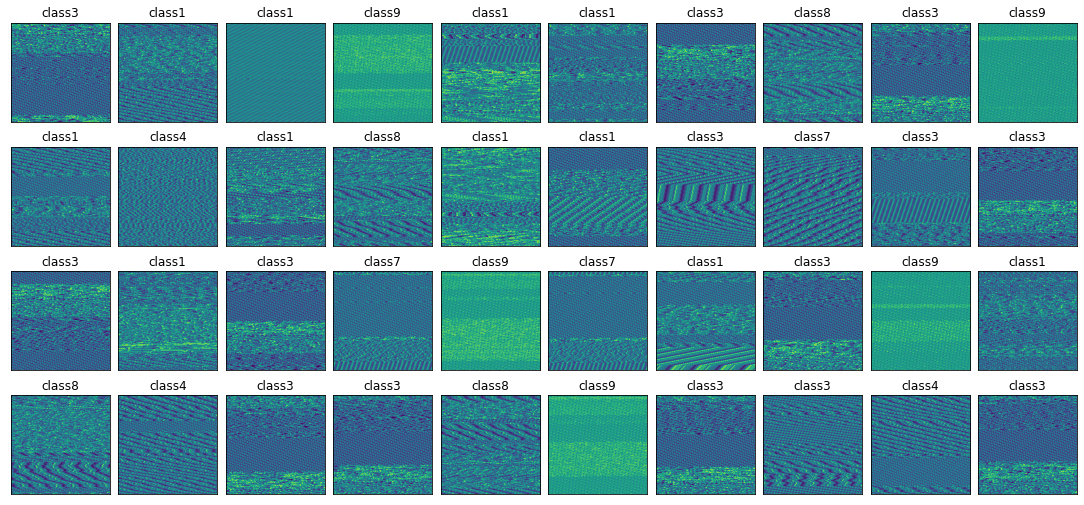

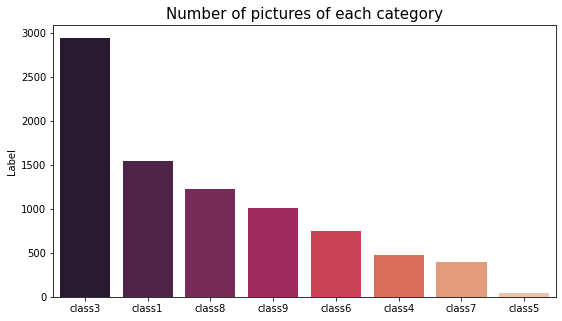

((7551, 2), (839, 2))

In [3]:
import os.path
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

from pathlib import Path
from tqdm import tqdm
from time import perf_counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score
from IPython.display import Markdown, display

# 이미지 경로를 데이터 프레임 형태로 만드는 함수
dir_ = Path('/content/drive/MyDrive/ColabNotebooks/CNN_Project/imagedata')
filepaths = list(dir_.glob(r'**/*.png')) # 사용자가 제시한 조건에 맞는 파일명을 리스트 형식으로 반환
def proc_img(filepath):
    """
   		이미지데이터의 경로와 label데이터로 데이터프레임 만들기 
    """
    labels = [str(filepath[i]).split("/")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # 경로와 라벨 concatenate, panda에 데이터프레임 합치는 함수.axis=1: 왼쪽+오른쪽으로 합치기
    df = pd.concat([filepath, labels], axis=1) 
                                              

    # index 재설정
    df = df.sample(frac=1,random_state=0).reset_index(drop = True) # dataframe에 랜덤하게 몇 %의 데이터를 뽑을 것인지.
                                                                   # frac=1:모든 데이터를 반환
    return df

df = proc_img(filepaths)
df.head(5)

print(f'Number of pictures: {df.shape[0]}\n') # Number of pictures: 13798
print(f'Number of different labels: {len(df.Label.unique())}\n') #Number of different labels: 8
print(f'Labels: {df.Label.unique()}') # unique()는 데이터에 고유값들이 어떠한 종류들이 있는지 알고 싶을 때 사용하는 함수
# Labels: ['person' 'airplane' 'car' 'dog' 'cat' 'flower' 'fruit' 'motorbike']

# 이미지 데이터 확인
fig, axes = plt.subplots(nrows=4, ncols=10, figsize=(15, 7), 
                        subplot_kw={'xticks': [], 'yticks': []}) # figsize:그래프 사이즈

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.Filepath[i]))
    ax.set_title(df.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()
# fig란 figure로써 - 전체 subplot을 말한다. ex) 서브플로안에 몇개의 그래프가 있던지 상관없이  그걸 담는 하나. 전체 사이즈를 말한다.
# ax는 axe로써 - 전체 중 낱낱개를 말한다 ex) 서브플롯 안에 2개(a1,a2)의 그래프가 있다면 a1, a2 를 일컬음


# Label Category 분포 확인
vc = df['Label'].value_counts()
plt.figure(figsize=(9,5))
sns.barplot(x = vc.index, y = vc, palette = "rocket")
plt.title("Number of pictures of each category", fontsize = 15)
plt.show()

#이미지 데이터 Train, Test 데이터로 분류
# Training/test split
# train_df,test_df = train_test_split(df.sample(frac=0.2), test_size=0.1,random_state=0) #모델링 시간이 오래걸리면 사용
train_df,test_df = train_test_split(df, test_size=0.1,random_state=0)
train_df.shape,test_df.shape


In [ ]:
import numpy as np
import tensorflow as tf


from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split=0.2)

train_gen = train_datagen.flow_from_directory('/content/drive/MyDrive/ColabNotebooks/CNN_Project/imagedata',
                                                 target_size = (256, 256),
                                                 batch_size = 32,
                                                 color_mode = 'grayscale',
                                                 class_mode = 'categorical',subset='training')
val_gen  = train_datagen.flow_from_directory('/content/drive/MyDrive/ColabNotebooks/CNN_Project/imagedata',
                                                 target_size = (256, 256),
                                                 batch_size = 32,
                                                 color_mode = 'grayscale',
                                                 class_mode = 'categorical',subset='validation')

Found 8698 images belonging to 10 classes.
Found 2170 images belonging to 10 classes.


In [ ]:
# Initialising the CNN
# Sequential API는 tensorflow2에서 뉴럴 네트워크를 가장 쉽게 구성할 수 있는 방식
# add함수를 이용하면 layer가 순차대로 연결됨.
# add함수를 통해 각 layer들은 정확히 하나의 input값만 받을 수 있으며
# output 또한 하나의 tensor 형태로만 출력이 가능
cnn = tf.keras.models.Sequential() # 케라스는 Sequential을 사용하여 층을 차례대로 쌓음

# Step 1 - Convolution 합성곱 층, 32만큼 특성맵이 만들어짐. 입력층이라고 볼 수 있음.
# 커널 사이즈 크면 특징 감지하는데 효과가 떨어짐 3이나 5로 함
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=[256, 256, 1])) 


# Step 2 - Pooling
# 특성맵 크기 줄이는 작업(압축)
# stride 이동하는 크기. stride가 2면 2픽셀씩 이동. 2 by 2 크기가 만들어짐
# 풀링의 크기는 2
# 높이와 너비 절반 줄어듦
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Adding convolutional layer
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
# 풀링으로 크기를 한 번 더 줄임
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Step 3 - Flattening
# Flatten() 입력 배열을 1차원으로 펼치는 역할. 연산 같은 거 없고 그냥 펼치는 역할. 
# 클래스 개수에 맞는 확률값을 얻기 위한 Dense 이전에 실행해야함.
# Dense 거치기 전에 먼저 flatten()으로 1차원으로 만들어야함
cnn.add(tf.keras.layers.Flatten())

# Step 4 - Full Connection
# 128개의 뉴런 거침.
cnn.add(tf.keras.layers.Dense(units=128, activation='relu'))

# Step 5 - Output Layer
# 9개의 출력 유닛을 가진 소프트맥스 층 추가, 최종적으로 9개 결과 출력
cnn.add(tf.keras.layers.Dense(units=9, activation='softmax')) 

# Compiling the CNN
cnn.compile(optimizer = 'adam',
            loss = 'categorical_crossentropy', # 3개 이상의 클래스를 분류할 경우에 사용
            metrics = ['accuracy'])
cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 254, 254, 32)      320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 125, 125, 32)      9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 123008)            0         
                                                                 
 dense_2 (Dense)             (None, 128)              

In [ ]:
#모델 성능확인
cnn.fit(x = train_gen, validation_data = val_gen, epochs = 10) #epochs는 학습 횟수

In [ ]:
def create_gen():
    # 생성기 및 데이터 증강으로 이미지 로드
    train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
        validation_split=0.1
    )

    test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
    )

    train_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath', # 파일위치 열이름
        y_col='Label', # 클래스 열이름
        target_size=(256, 256), # 이미지 사이즈
        color_mode='rgb', # 이미지 채널수
        class_mode='categorical', # Y값(Label값)
        batch_size=32,
        shuffle=True, # 데이터를 섞을지 여부
        seed=0,
        subset='training', # train 인지 val인지 설정
        rotation_range=30, # 회전제한 각도 30도
        zoom_range=0.15, # 확대 축소 15%
        width_shift_range=0.2, # 좌우이동 20%
        height_shift_range=0.2, # 상하이동 20%
        shear_range=0.15, # 반시계방햐의 각도
        horizontal_flip=True, # 좌우 반전 True
        fill_mode="nearest"
        # 이미지 변경시 보완 방법 (constant, nearest, reflect, wrap) 4개 존재
    )

    val_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(256, 256),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='validation',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest" #이미지를 축소하거나 이동할 때 공간을 채우는 방식
    )

    test_images = test_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(256, 256),
        color_mode='rgb', 
        class_mode='categorical',
        batch_size=32,
        shuffle=False
    )
    
    return train_generator,test_generator,train_images,val_images,test_images

In [ ]:
models = {
    #다양한 모델들 종류!
    "DenseNet121": {"model":tf.keras.applications.DenseNet121, "perf":0},
    "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
    "DenseNet201": {"model":tf.keras.applications.DenseNet201, "perf":0},
    "EfficientNetB0": {"model":tf.keras.applications.EfficientNetB0, "perf":0},
    "EfficientNetB1": {"model":tf.keras.applications.EfficientNetB1, "perf":0},
    "InceptionV3": {"model":tf.keras.applications.InceptionV3, "perf":0},
    "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
    "MobileNetV3Large": {"model":tf.keras.applications.MobileNetV3Large, "perf":0},
    "ResNet152V2": {"model":tf.keras.applications.ResNet152V2, "perf":0},
    "ResNet50": {"model":tf.keras.applications.ResNet50, "perf":0},
    "ResNet50V2": {"model":tf.keras.applications.ResNet50V2, "perf":0},
    "VGG19": {"model":tf.keras.applications.VGG19, "perf":0},
    "VGG16": {"model":tf.keras.applications.VGG16, "perf":0},
    "Xception": {"model":tf.keras.applications.Xception, "perf":0}
}
# Create the generators
train_generator,test_generator,train_images,val_images,test_images=create_gen()
print('\n')

def get_model(model):
# Load the pretained model
    kwargs =    {'input_shape':(256, 256, 3),
                'include_top':False,
                'weights':'imagenet',
                'pooling':'avg'}
    
    pretrained_model = model(**kwargs)
    pretrained_model.trainable = False # 레이어를 동결 시켜서 훈련중 손실을 최소화 한다.
    
    inputs = pretrained_model.input

    x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
    x = tf.keras.layers.Dense(128, activation='relu')(x)

    outputs = tf.keras.layers.Dense(5, activation='softmax')(x)
    # 라벨 개수가 8개이기 때문에 Dencs도 8로 설정
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Train모델 학습
for name, model in models.items():
    
    # 전이 학습 모델 가져오기
    m = get_model(model['model'])
    models[name]['model'] = m
    
    start = perf_counter()
    
    # 모델 학습
    history = m.fit(train_images,validation_data=val_images,epochs=1,verbose=0) #verbose는 진행상황을 보여주는 것
    
    # 학습시간과 val_accuracy 저장
    duration = perf_counter() - start
    duration = round(duration,2)
    models[name]['perf'] = duration
    print(f"{name:20} trained in {duration} sec")
    
    val_acc = history.history['val_accuracy']
    models[name]['val_acc'] = [round(v,4) for v in val_acc]

In [ ]:
# test데이터로 모델 성능 예측
#정확도가 떨어지는 것 같은데 이는 그레이 스케일이 아니라 rgb로 받아와서 그런 것 같음 아직 그걸 해결 못 함 
for name, model in models.items():
    
    # Predict the label of the test_images
    pred = models[name]['model'].predict(test_images)
    pred = np.argmax(pred,axis=1)

    # Map the label
    labels = (train_images.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    pred = [labels[k] for k in pred]

    y_test = list(test_df.Label)
    acc = accuracy_score(y_test,pred)
    models[name]['acc'] = round(acc,4)
    print(f'**{name} has a {acc * 100:.2f}% accuracy on the test set**')
   
# Create a DataFrame with the results
models_result = []

for name, v in models.items():
    models_result.append([ name, models[name]['val_acc'][-1], 
                          models[name]['acc'],
                          models[name]['perf']])
    
df_results = pd.DataFrame(models_result, 
                          columns = ['model','val_accuracy','accuracy','Training time (sec)'])
df_results.sort_values(by='accuracy', ascending=False, inplace=True)
df_results.reset_index(inplace=True,drop=True)
df_results

In [ ]:
#정확도 비교
plt.figure(figsize = (15,5))
sns.barplot(x = 'model', y = 'accuracy', data = df_results)
plt.title('Accuracy on the test set (after 1 epoch))', fontsize = 15)
plt.ylim(0,1)
plt.xticks(rotation=90)
plt.show()

In [ ]:
#시간을 비교
plt.figure(figsize = (15,5))
sns.barplot(x = 'model', y = 'Training time (sec)', data = df_results)
plt.title('Training time for each model in sec', fontsize = 15)
# plt.ylim(0,20)
plt.xticks(rotation=90)
plt.show()

In [ ]:
class_report = classification_report(y_test, pred, zero_division=1)
print(class_report)

In [ ]:
# from PIL import Image
import pandas as pd
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input

fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(20, 12),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i])) #imshow() 함수를 이용하면 영상을 출력할 수 있습니다.
    ax.set_title(f"True: {test_df.Label.iloc[i].split('_')[0]}\nPredicted: {pred[i].split('_')[0]}", fontsize = 15)
plt.tight_layout()
plt.show()

In [ ]:
!unzip -qq /content/drive/MyDrive/ColabNotebooks/CNN_Project/imagedata/image.zip -d /content/drive/MyDrive/ColabNotebooks/CNN_Project/imagedata

In [ ]:
import shutil
shutil.rmtree('경로')